In [1]:
import pickle
import torch 
import control as ct
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from cr3bp import EarthMoon
import cr3bp
from random import randint
import numpy.random as npr
from matplotlib import pyplot as plt, patches
import matplotlib as mpl
import torch.optim as optim
from torch.utils.data import random_split
from numpy import linalg as LA
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())
!nvidia-smi
device = torch.device("cuda:0")

True
Sun Mar 10 23:22:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:06:00.0  On |                  N/A |
| 30%   41C    P2   135W / 350W |   1485MiB / 24576MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [2]:
# function to output the time derivative state space dynamics of the satellite in the CR3BP
def CR3BPdyn(t,x,mu):
    
    ax = x[0]+2*x[4]-((1-mu)*(x[0]+mu))/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*(x[0]-(1-mu)))/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in x-dir based on CR3BP
    ay = x[1]-2*x[3]-((1-mu)*x[1])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[1])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in y-dir based on CR3BP
    az = -((1-mu)*x[2])/((x[0]+mu)**2+x[1]**2+x[2]**2)**(3/2)-(mu*x[2])/((x[0]-(1-mu))**2+x[1]**2+x[2]**2)**(3/2) # acceleration in z-dir based on CR3BP

    fdyn = np.array([x[3], x[4], x[5], ax, ay, az])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, mu, _dt, **kwargs):
    """
    single-step fourth-order numerical integration (RK4) method
    func: system of first order ODEs
    tk: current time step
    _yk: current state vector [y1, y2, y3, ...]
    _dt: discrete time step size
    **kwargs: additional parameters for ODE system
    returns: y evaluated at time k+1
    """

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk, mu, **kwargs)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), mu, **kwargs)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), mu, **kwargs)
    f4 = func(tk + _dt, _yk + (f3 * _dt), mu, **kwargs)

    # return an average of the derivative over tk, tk + dt
    return np.array(_yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4))

In [3]:
# Complete orbit dataset, either constant dt or constant dp depending on data generator
data_x = torch.load("X_Data.pt").to(torch.float32)
data_y = torch.load("Y_Data.pt").to(torch.float32)
data_y2 = torch.load("Y2_Data.pt").to(torch.float32)

with open('CR3BP_variables_data.pkl', 'rb') as f: # remove 3D for 3D array
    dp,tf,nx,m,predict_time = pickle.load(f)
    
# train-test split for evaluation of the model
loader = DataLoader(list(zip(data_x, data_y, data_y2)), shuffle=True, batch_size=8)

# ***Building the Network***

In [4]:
# Hyper-parameters j
input_size = nx 
lifted_space = 80
hidden_size = 95
learning_rate = 0.000001
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1).to(device)

class Encoder(nn.Module):
    def __init__(self, input_size, lifted_space):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, lifted_space)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
          encoded = self.encoder(x)
          return encoded         

modelen = Encoder(input_size, lifted_space).to(device)
criterion = torch.nn.MSELoss().to(device) # mean squared loss 
optimizer = optim.Adamax(list(modelen.parameters()), lr=learning_rate, weight_decay=1e-5)

# ***Training***

In [5]:
num_epochs = 3000
Loss = []
Loss_prev = 1e38
num_tests = 50
iterations = 3

for iter in range(iterations): 
    i = 0
    j = 0

    for epoch in range(num_epochs):
        # ~~~~~~~~~~~~~~ for batch training 3D array ~~~~~~~~~~~~~~~~~#
        for part_x, part_y, part_y2 in loader:

            #~~~~~~~~~~~~~~~~ original data type, constant dp, 3D array ~~~~~~~~~~~~~~~~~~~~~~#
            part_x = part_x.reshape([int(len(part_x)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            part_y = part_y.reshape([int(len(part_y)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            part_y2 = part_y2.reshape([int(len(part_y2)*(dp)),nx]).to(device) # reshaping to stack all initial conditions on top of each other
            transpose_y_train  = torch.transpose(part_y,0,1).to(device)    # transpose to fit the model
            transpose_y2_train  = torch.transpose(part_y2,0,1).to(device)    # transpose to fit the model
            transpose_x_train  = torch.transpose(part_x,0,1).to(device)    # transpose to fit the model

            phi_k = torch.transpose(modelen(part_x.to(device)),0,1).to(device)    # encoded x data
            K_phi_k = torch.cat((transpose_x_train,phi_k),0).to(device)           # adding the original states to the encoded x data

            phi_k_plus_one = torch.transpose(modelen(part_y2.to(device)),0,1).to(device)   # encoded y data
            K_phi_k_plus_one = torch.cat((transpose_y2_train,phi_k_plus_one),0).to(device) # adding the original states to the encoded y data

            #~~~~~~~~~~~~~~~~~~ EDMD with control ~~~~~~~~~~~~~~~~~#

            # W = torch.cat((K_phi_k,transpose_u_train),0)  
            # V = K_phi_k_plus_one 

            # Vwt = torch.matmul(V,torch.transpose((W),0,1))
            # Wwt = torch.matmul(W,torch.transpose((W),0,1))
            # KB = torch.matmul(Vwt,torch.pinverse(Wwt))
            # K = KB[:,0:-m]
            # B = KB[:,-m:]
            
            #~~~~~~~~~~~~~~~~~~~~~ EDMD ~~~~~~~~~~~~~~~~~~~~~~#

            K = torch.matmul(K_phi_k_plus_one,torch.pinverse(K_phi_k)) # find Koopman K using EDMD


            #~~~~~~~~~~~~~~~ One Time Step Prediction loss ~~~~~~~~~~~~~~~~~~~~~~#

            K_phi_plus_one = torch.matmul(K,K_phi_k) #+ torch.matmul(B,transpose_u_train)

            x_plus_one = torch.matmul(P,K_phi_plus_one)

            # Forward pass and loss calculation
            loss_2 = criterion(x_plus_one, transpose_y2_train) # Koopman loss (finds K) EDMD loss
            
            #~~~~~~~~~~~~~~~~~ Multiple Time Step Predicition Loss ~~~~~~~~~~~~~~~~~#
            for l in range(predict_time):
                next_phi = torch.matmul(K,K_phi_k) #+ torch.matmul(B,transpose_u_train) # K: This is the linear operation. 
                next_state = torch.matmul(P,next_phi) # extracting the next state
                next_state_encoded = modelen(torch.transpose(next_state,0,1).to(device)) # stacking original states on 
                K_phi_k = torch.transpose(torch.cat((torch.transpose(next_state,0,1).to(device),next_state_encoded),1),0,1)

            loss_x = next_state
            loss_y = transpose_y_train

            # Forward pass and loss calculation
            loss_1 = criterion(loss_x, loss_y) # Koopman loss (finds K) EDMD loss
            loss_1_lambda = 2

            # loss_x2 = torch.matmul(K,K_phi_k)
            # loss_y2 = K_phi_k_plus_one
            # loss_2 = criterion(loss_x2, loss_y2)
            loss_2_lambda = 1
            
            l1_lambda = 0.004
            l1_regularisation = sum(p.norm().sum()
                  for p in modelen.parameters())
            loss_L1 = l1_lambda * l1_regularisation

            l2_lambda = 0.001
            l2_regularisation = sum(p.pow(2.0).sum()
                  for p in modelen.parameters())
            loss_L2 = l2_lambda * l2_regularisation

            loss = loss_1_lambda*loss_1 + loss_2_lambda*loss_2 + loss_L1 + loss_L2
            
            # Backward and optimize
            optimizer.zero_grad() # find the gradients.
            loss.backward(retain_graph=True)       # needed for multiple loss functions.  Not need for one loss function. We have 2.
            optimizer.step()      # updates the weights for the each parameter.

            # storing the K and PK values and model of the best model trained so far
            if loss.item() < Loss_prev or (iter == 0 and epoch == 0):
                best_model = modelen
                torch.save(modelen, 'CR3BP-model305.pt')
                K_best = K
                # storing the best K and PK to a data file
                with open('CR3BPobjs305.pkl', 'wb') as f:
                    pickle.dump(K_best, f)
                Loss_prev = loss.item()
            modelen = best_model

                # logging of losses
        if (i+1) % 100 == 0:
            print (f'Iteration: [{iter+1}/{iterations}],   Epoch: [{epoch+1}/{num_epochs}],  Loss: {loss.item():.15f},   L1 Loss: {loss_L1}, L2 Loss: {loss_L2}')
        i = i+1
        Loss.append(loss.item())

        # storing the loss to a data file
        with open('CR3BPloss305.pkl', 'wb') as lf:
            pickle.dump(Loss, lf)

Iteration: [1/3],   Epoch: [100/3000],  Loss: 3.080782890319824,   L1 Loss: 0.9051881432533264, L2 Loss: 2.173642873764038
Iteration: [1/3],   Epoch: [200/3000],  Loss: 3.048975467681885,   L1 Loss: 0.8997739553451538, L2 Loss: 2.1480791568756104
Iteration: [1/3],   Epoch: [300/3000],  Loss: 3.015498161315918,   L1 Loss: 0.8939184546470642, L2 Loss: 2.1205251216888428
Iteration: [1/3],   Epoch: [400/3000],  Loss: 2.980545997619629,   L1 Loss: 0.8877947926521301, L2 Loss: 2.0918447971343994
Iteration: [1/3],   Epoch: [500/3000],  Loss: 2.942180156707764,   L1 Loss: 0.881043016910553, L2 Loss: 2.0603644847869873
Iteration: [1/3],   Epoch: [600/3000],  Loss: 2.903472661972046,   L1 Loss: 0.874171257019043, L2 Loss: 2.02854585647583
Iteration: [1/3],   Epoch: [700/3000],  Loss: 2.862924337387085,   L1 Loss: 0.8669841289520264, L2 Loss: 1.995490312576294
Iteration: [1/3],   Epoch: [800/3000],  Loss: 2.825464248657227,   L1 Loss: 0.8602287173271179, L2 Loss: 1.9646646976470947
Iteration: [1/

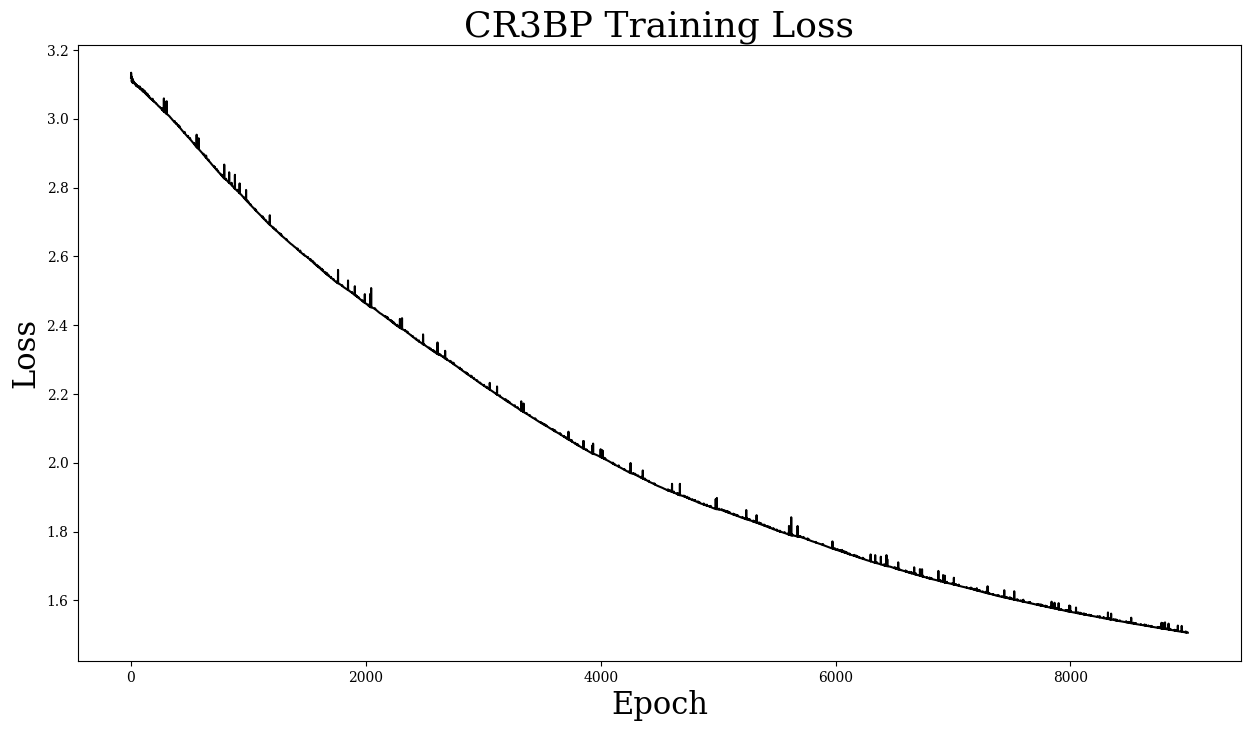

In [6]:
with open('CR3BPloss305.pkl', 'rb') as lf: 
    Loss = pickle.load(lf)

# plotting training loss
mpl.rc('font',family='Serif')
fig, ax = plt.subplots(figsize = (15, 8))
lns = ax.plot(Loss, color='black', label = 'RLDK model')
ax.set_xlabel("Epoch", fontsize = 22)
ax.set_ylabel('Loss', fontsize = 22)
ax.set_title("CR3BP Training Loss", fontsize=26)
plt.show()

In [7]:
modelen = torch.load('CR3BP-model305.pt')
with open('CR3BPobjs305.pkl', 'rb') as f: 
    K = pickle.load(f)

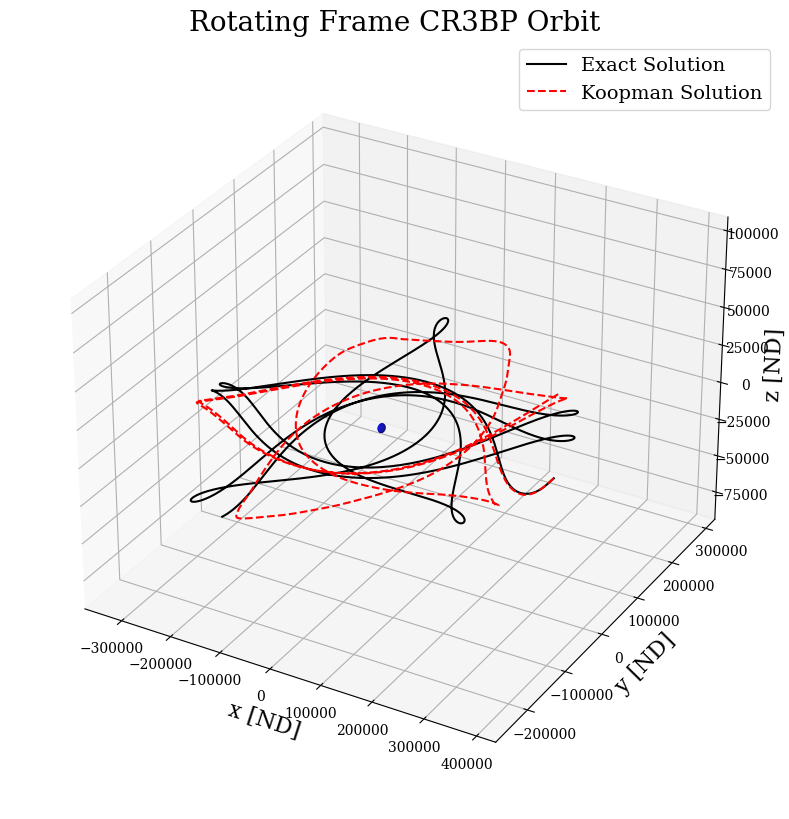

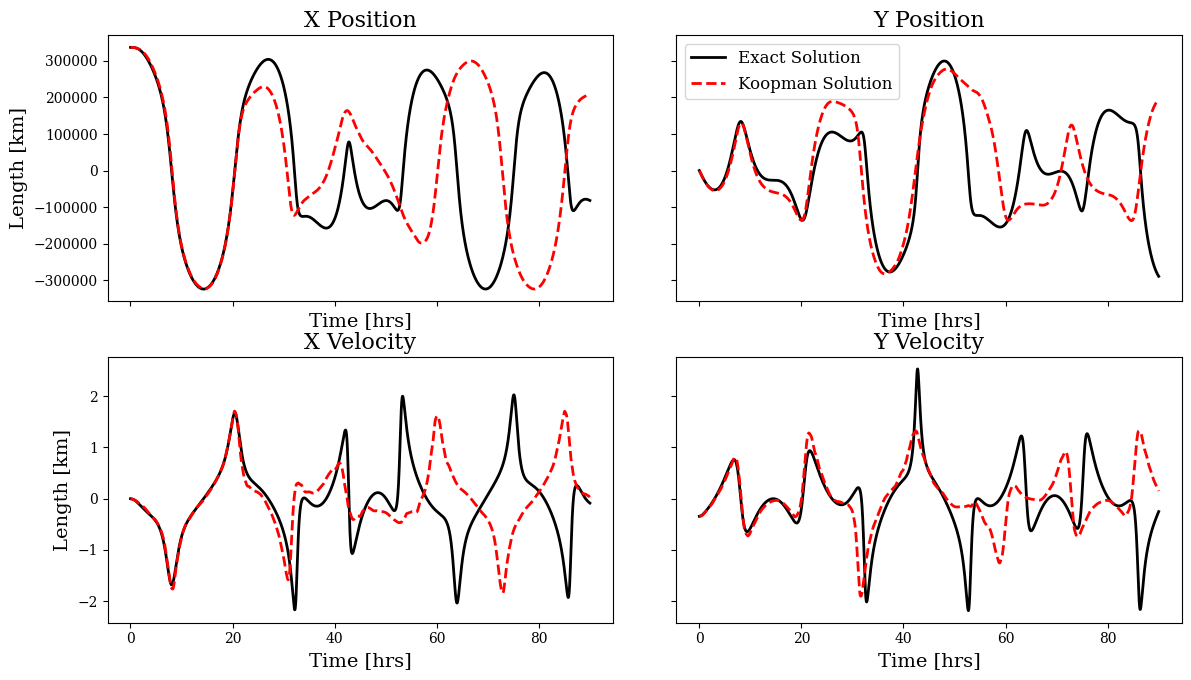

In [8]:
# CR3BP parameters
G = 6.67408E-20  # Univ. Gravitational Constant [km3 kg-1 s-2]
mEarth = 5.97219E+24  # Mass of the Earth [kg]
mMoon = 7.34767E+22  # Mass of the Moon [kg]
a = 3.844E+5  # Semi-major axis of Earth and Moon [km]
m1 = mEarth
m2 = mMoon
Mstar = m1+m2  # ND Mass Parameter
Lstar = a  # ND Length Parameter
Tstar = (Lstar**3/(G*Mstar))**(1/2)  # ND Time Parameter
mu = m2/Mstar

tf = 90*86400/Tstar
dp = 2000
error_prev = 1e38
error = np.zeros((500))
idx = 0
# for j in range(4600, 4800):
EM = cr3bp.EarthMoon
eoms = cr3bp.EOMConstructor(EM.mu)
# randomiser = 1 + randint(0,499)/10000 + randint(0,9)/100000
# randomiser = 1.04754
# randomiser = 1.04765
randomiser = 1.04785
# randomiser = 1 + j/100000
IC = [randomiser*EM.L1 + 1/EM.l, 0, 0, 0, 0, 0]
IC[3:5] = cr3bp.initial_velocity(IC[:2], EM.L1, EM.mu)
x0_CR3BP = torch.tensor(IC).type(torch.FloatTensor)
time = np.linspace(0, tf, dp)
dt = tf/dp
xk = x0_CR3BP
sol = np.empty([6,])
X = np.empty([nx,])
initial_phi_without_states = torch.transpose(modelen(x0_CR3BP.to(device)),0,0)
initial_phi = torch.cat((torch.transpose(x0_CR3BP.to(device),0,0),initial_phi_without_states),0).cpu()

# ~~~~~~ Creating tensors to store system states ~~~~~~~ #
new_states = torch.zeros(nx,dp).cpu()
next_state = x0_CR3BP
phi_i = initial_phi
i=0
# ~~~~~~ System Evolution ~~~~~~~ #
for t in time:

    # ~~~~~~~ Koopman Model with Kalman Filter ~~~~~~~ #
    new_states[:,i] = next_state # saving states
    phi_ip1 = torch.matmul(K.cpu(), phi_i)
    next_state = torch.matmul(P.cpu(),phi_ip1).cpu() # extracting the next state
    next_state_encoded = torch.transpose(modelen(next_state.to(device)),0,0) # stacking original states on 
    phi_i = torch.cat((next_state.to(device),next_state_encoded),0).cpu()
    
    # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
    sol = np.vstack((sol, xk))
    xk = rk4(CR3BPdyn, t, xk, mu, dt) # RK4 approximation of solution
    i = i+1

sol = sol[1:,:]
time = time*EM.seconds/86400

X_true = sol[:,0]*Lstar
Y_true = sol[:,1]*Lstar
Z_true = sol[:,2]*Lstar

new_states = torch.transpose(new_states,0,1).detach().numpy()
X_lin = new_states[:,0]*Lstar
Y_lin = new_states[:,1]*Lstar
Z_lin = new_states[:,2]*Lstar

    # error[j-4600] = np.abs(np.sum((X_true - X_lin) + (Y_true - Y_lin) + (Z_true - Z_lin)))
    # if error[j-4600] < error_prev:
    #     idx = randomiser
    #     error_prev = error[j-4600]



# m1_loc = [-mu, 0, 0]
# m2_loc = [(1-mu), 0, 0]
m1_loc = [0, 0, 0]
m2_loc = [Lstar, 0, 0]

# Rotating Frame Plot
mpl.rc('font',family='Serif')
fig = plt.figure(figsize = (15, 10))
# fig.tight_layout(pad = 3.0)
ax = plt.axes(projection='3d')
ax.set_box_aspect(aspect=None,zoom=0.95)

# Adding Figure Title and Labels
ax.set_title('Rotating Frame CR3BP Orbit', fontsize=20)
ax.set_xlabel('x [ND]',fontsize=16)
ax.set_ylabel('y [ND]',fontsize=16)
ax.set_zlabel('z [ND]',fontsize=16)

# Plotting Rotating Frame Positions
u = np.linspace(0,2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))

ax.plot_surface(m1_loc[0]+6370*x, m1_loc[1]+6370*y, m1_loc[2]+2870*z, color='blue',)
ax.plot_surface(m2_loc[0]+0.05*x, m2_loc[1]+0.0375*y, m2_loc[2]+0.0175*z, color='grey')

ax.plot3D(X_true, Y_true, Z_true, c='black', label='Exact Solution')
ax.plot3D(X_lin, Y_lin, Z_lin, c='red',label='Koopman Solution', linestyle='--')

# ax.plot3D(m1_loc[0], m1_loc[1], m1_loc[2], c='blue', label='Earth', marker='o')
# ax.plot3D(m2_loc[0], m2_loc[1], m2_loc[2], c='grey', label='Moon', marker='o')
ax.legend(fontsize=14)

# Setting Axis Limits
xyzlim = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()]).T
XYZlim = np.asarray([min(xyzlim[0]), max(xyzlim[1])])
ax.set_xlim3d(XYZlim)
ax.set_ylim3d(XYZlim * 3/4)
ax.set_zlim3d(XYZlim * 1/4)

# Plotting states
fig2, ax2 = plt.subplots(2, 2, sharex = 'col', sharey = 'row', figsize = (12, 7))
fig2.tight_layout(pad = 3.0)
colours = ['black', 'red','deepskyblue']
line = ['-', '--',':']
titles = ['X Position', 'Y Position', 'X Velocity', 'Y Velocity']
plot_lines = []
for i in range(4):
    if i == 0:
        a = 0
        b = 0
        j = 0
    elif i == 1:
        a = 0
        b = 1
        j = 1
    elif i == 2:
        a = 1
        b = 0
        j = 3
    elif i == 3:
        a = 1
        b = 1
        j = 4
    p1, = ax2[a,b].plot(time, sol[:,j]*EM.conversion_vector[j]*1e-3, color=colours[0], linestyle=line[0], label='Exact Solution', linewidth=2)
    p2, = ax2[a,b].plot(time, new_states[:,j]*EM.conversion_vector[j]*1e-3, color=colours[1], linestyle=line[1], label='Koopman Solution', linewidth=2)
    # p3, = ax2[a,b].plot(time, sol[:,j]*EM.conversion_vector[j]*1e-3 - new_states[:,j]*EM.conversion_vector[j]*1e-3)
    ax2[a,b].set_title(titles[i], fontsize = 16)
    ax2[a,b].set_xlabel("Time [hrs]", fontsize = 14)
    ax2[a,0].set_ylabel("Length [km]", fontsize = 14)
ax2[0,1].legend(fontsize=12)
# ax2[1,0].set_xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],[0, 0.20, 0.40, 0.60, 0.80, 1, 1.20, 1.40, 1.60, 1.80, 2.00])
# ax2[1,1].set_xticks([0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],[0, 0.20, 0.40, 0.60, 0.80, 1, 1.20, 1.40, 1.60, 1.80, 2.00])

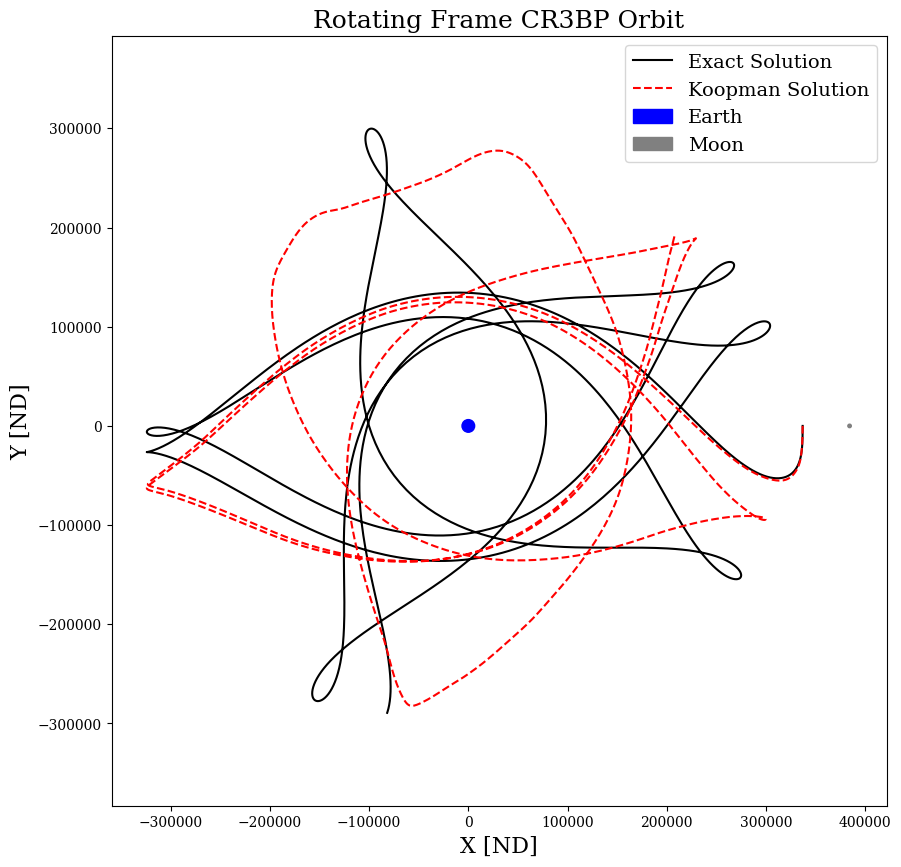

In [9]:
fig3 = plt.figure(figsize = (10, 10))
ax3 = plt.axes()

# Adding Figure Title and Labels
ax3.set_title('Rotating Frame CR3BP Orbit', fontsize=18)
ax3.set_xlabel('X [ND]', fontsize=16)
ax3.set_ylabel('Y [ND]', fontsize=16)


# Plotting Rotating Frame Positions
ax3.plot(X_true, Y_true, c='black', label='Exact Solution')
ax3.plot(X_lin, Y_lin, linestyle='--', c='red', label='Koopman Solution')
Earth = patches.Circle((m1_loc[0], m1_loc[1]), 6370, color='blue', label='Earth')
Moon = patches.Circle((m2_loc[0], m2_loc[1]), 1740, color='grey', label='Moon')

ax3.add_patch(Earth)
ax3.add_patch(Moon)
ax3.axis('equal')
ax3.legend(fontsize=14)

Text(0.5, 0.98, 'Error in Position States - CR3BP')

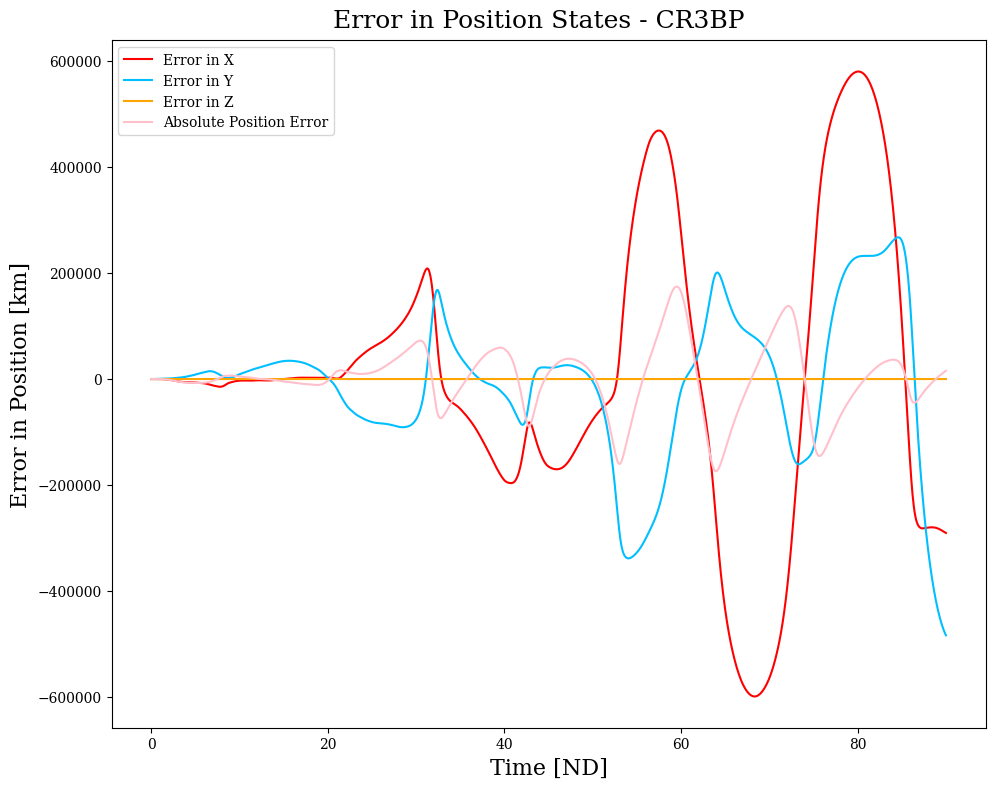

In [10]:
# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
errorX = (X_true - X_lin)
errorY = (Y_true - Y_lin)
errorZ = (Z_true - Z_lin)

error = np.sqrt(X_true**2 + Y_true**2 + Z_true**2) - np.sqrt(X_lin**2 + Y_lin**2 + Z_lin**2)
# meanX = np.mean(X_true)
# errorX = errorX/meanX
# meanY = np.mean(Y_true)
# errorY = errorY/meanY
# meanZ = np.mean(Z_true)
# errorZ = errorZ/meanZ
colours = ['black', 'red','deepskyblue', 'orange', 'pink', 'silver']

# Setting up Error plot
fig4 = plt.figure(figsize = (10,8))
ax4 = plt.axes()
fig4.tight_layout(pad = 3.0)
ax4.plot(time, errorX, color=colours[1], label='Error in X')
ax4.plot(time, errorY, color=colours[2], label = 'Error in Y')
ax4.plot(time, errorZ, color=colours[3], label = 'Error in Z')
ax4.plot(time, error, color=colours[4], label = 'Absolute Position Error')
ax4.set_xlabel('Time [ND]', fontsize = 16)
ax4.set_ylabel('Error in Position [km]', fontsize = 16)
ax4.legend()
fig4.suptitle('Error in Position States - CR3BP', fontsize = 18)
# ax4.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],[0, 0.125, 0.25, 0.375, 0.500, 0.625, 0.750, 0.875, 1.00])

# ***Metrics***

In [11]:
def JacobiConstant(states):
    x = states[:,0]
    y = states[:,1]
    z = states[:,2]
    xdot = states[:,3]
    ydot = states[:,4]
    zdot = states[:,5]

    d = np.sqrt((x+mu)**2 + y**2 + z**2)
    r = np.sqrt((x-1+mu)**2 + y**2 + z**2)
    OmegaStar = (1-mu)/d + mu/r + (x**2 + y**2)/r
    v = np.sqrt(xdot**2 + ydot**2 + zdot**2)

    return 2*OmegaStar - v**2

In [12]:
def Jacobi2(states):
    x = states[:,0]
    y = states[:,1]
    z = states[:,2]
    xdot = states[:,3]
    ydot = states[:,4]
    zdot = states[:,5]

    Omega = np.sqrt(mu)
    r = np.sqrt(x**2 + y**2 + z**2)
    v = np.sqrt(xdot**2 + ydot**2 + zdot**2)
    mu1 = mEarth/(mEarth+mMoon)

    return (Omega**2)*(r**2) + 2*mu1/-mu + 2*mu/(1-mu) - v**2

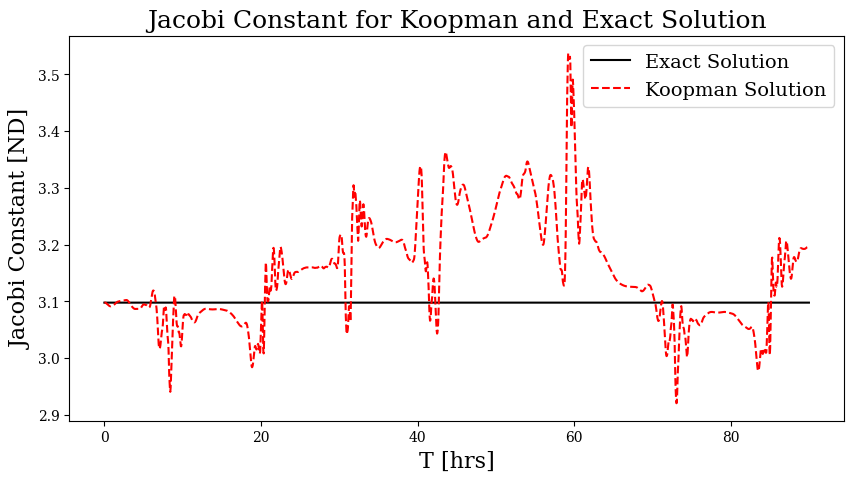

In [13]:
def Jacobi3(states,mu):
    x = states[:,0]
    y = states[:,1]
    z = states[:,2]
    xdot = states[:,3]
    ydot = states[:,4]
    zdot = states[:,5]

    mu1 = 1-mu
    mu2 = mu
    r1 = np.sqrt((x+mu2)**2 + y**2 + z**2)
    r2 = np.sqrt((x-mu1)**2 + y**2 + z**2)
 
    return (x**2 + y**2) + 2*(mu1/r1 + mu2/r2) - xdot**2 - ydot**2 - zdot**2

true = Jacobi3(sol,mu)
exp = Jacobi3(new_states,mu)
fig5 = plt.figure(figsize = (10, 5))
ax5 = plt.axes()

# Adding Figure Title and Labels
ax5.set_title('Jacobi Constant for Koopman and Exact Solution', fontsize=18)
ax5.set_xlabel('T [hrs]', fontsize=16)
ax5.set_ylabel('Jacobi Constant [ND]', fontsize=16)
# ax5.set_xticks([0, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],[0, 0.125, 0.25, 0.375, 0.50, 0.625, 0.75, 0.875, 1.00])

# Plotting Rotating Frame Positions
ax5.plot(time, true, c='black')
ax5.plot(time, exp, linestyle='--', c='red')
ax5.legend(labels=['Exact Solution', 'Koopman Solution'],fontsize=14)

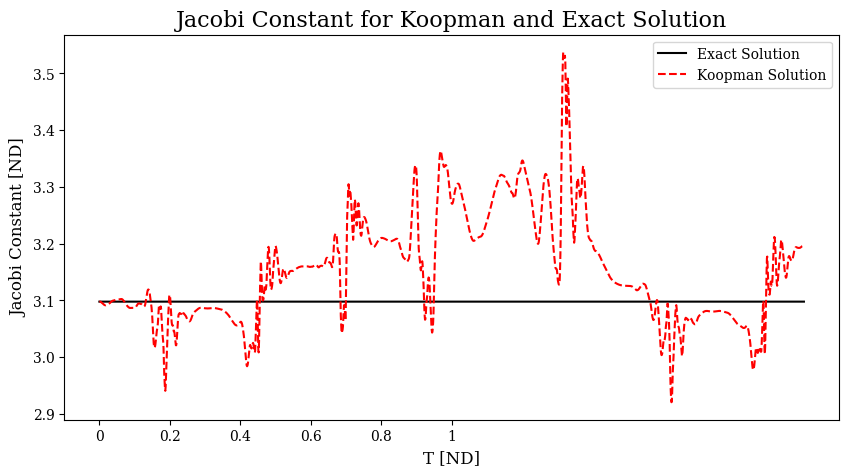

In [14]:
true = Jacobi3(sol,mu)
exp = Jacobi3(new_states,mu)
fig5 = plt.figure(figsize = (10, 5))
ax5 = plt.axes()

# Adding Figure Title and Labels
ax5.set_title('Jacobi Constant for Koopman and Exact Solution', fontsize=16)
ax5.set_xlabel('T [ND]', fontsize=12)
ax5.set_ylabel('Jacobi Constant [ND]', fontsize=12)
ax5.set_xticks([0, 200, 400, 600, 800, 1000],[0, 0.20, 0.40, 0.60, 0.80, 1])

# Plotting Rotating Frame Positions
ax5.plot(true, c='black')
ax5.plot(exp, linestyle='--', c='red')
ax5.legend(labels=['Exact Solution', 'Koopman Solution'])

In [15]:
LA.eig(K.cpu().detach().numpy())

(array([0.9507389 +0.23187296j, 0.9507389 -0.23187296j,
        0.94304985+0.22029991j, 0.94304985-0.22029991j,
        0.9627938 +0.19420937j, 0.9627938 -0.19420937j,
        0.9588986 +0.16878802j, 0.9588986 -0.16878802j,
        0.95701116+0.14991526j, 0.95701116-0.14991526j,
        0.9678265 +0.14427266j, 0.9678265 -0.14427266j,
        0.9751472 +0.1396206j , 0.9751472 -0.1396206j ,
        0.9789272 +0.13031662j, 0.9789272 -0.13031662j,
        0.9653571 +0.10935178j, 0.9653571 -0.10935178j,
        0.9810766 +0.1101307j , 0.9810766 -0.1101307j ,
        0.9737145 +0.09842563j, 0.9737145 -0.09842563j,
        0.9826196 +0.09123294j, 0.9826196 -0.09123294j,
        0.9565043 +0.08093338j, 0.9565043 -0.08093338j,
        0.9749324 +0.08624351j, 0.9749324 -0.08624351j,
        0.9850523 +0.0779452j , 0.9850523 -0.0779452j ,
        0.97441113+0.07112881j, 0.97441113-0.07112881j,
        0.98810047+0.06878901j, 0.98810047-0.06878901j,
        0.9822146 +0.06503385j, 0.9822146 -0.065